In [1]:
%reset -f

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gurobipy as gp
import igraph as ig

from numpy import sqrt
from gurobipy import GRB
from pyinstrument import Profiler
from numba import jit

plt.style.use('default')                                    # 使用默认风格
plt.rcParams['figure.facecolor'] = 'white'                  # 将图形的背景颜色设置为白色
plt.rcParams['font.family'] = 'YaHei Consolas Hybrid'       # 字体确认
plt.rcParams['font.size'] = 12                              # 字体大小
plt.rcParams['axes.unicode_minus'] = False                  # 正常显示负号
%matplotlib inline
#matplotlib.use('TkAgg')

In [2]:
## 数据读取与参数设置
def dist(p1, p2):
    return sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def viaShop(p1, p2, p3):
    return dist(p1, p2) + dist(p2, p3)

def Charge_viaShop(p1, p2, p3, p4):
    return dist(p1, p2) + dist(p2, p3) + dist(p3, p4)


# 数据读取
df1 = pd.read_excel('./q1data.xlsx')
pattern = r'\((-?\d+\.\d+), (-?\d+\.\d+)\)'
df1[['x', 'y']] = df1['坐标'].str.extract(pattern)
df1[['x', 'y']] = df1[['x', 'y']].astype(float)
df1['points'] = df1.apply(lambda row: [row['x'], row['y']], axis=1)
df1.drop(columns=['x', 'y', '坐标'], inplace=True)

# 参数设置
M = 1 << 16
droneSpeed = 60
droneMaxPower = 10
droneNumber = 1
userNumber = df1.shape[0]

shop = [[0.5, 0]]
chargeStation = [0, 0]
ep = [0 ,0]

# 构建耗时矩阵
matSize = 2 * userNumber + 2
distMat = np.full((matSize, matSize), float(M))
for i in range(2 * userNumber + 1):
    for j in range(1, 2 * userNumber + 2):
        if i >= 1:
            userPoint1 = df1.loc[(i - 1) % userNumber, 'points']
        if j >= 1:
            userPoint2 = df1.loc[(j - 1) % userNumber, 'points']
        # 起点到某处
        if 1 <= j <= userNumber:
            if i == 0:
                distMat[i, j] = viaShop(chargeStation, shop[0], userPoint2)
            else:
                distMat[i, j] = viaShop(userPoint1, shop[0], userPoint2) 
        elif userNumber + 1 <= j <= 2 * userNumber:
            if i == 0:
                continue
            else:
                distMat[i, j] = Charge_viaShop(userPoint1, chargeStation, shop[0], userPoint2)
        elif j == 2 * userNumber + 1:
            if i == 0:
                continue
            else:
                distMat[i, j] = dist(userPoint1, chargeStation)
                                

In [3]:
## 第一问线性规划

# 确认分块点集
Sp = [0]
Ep = [matSize - 1]
I1 = list(range(1, userNumber + 1))
I2 = list(range(userNumber + 1, 2 * userNumber + 1))
U = Sp + I1 + I2 + Ep


prob1 = gp.Model('q1无人机调度')

x = prob1.addVars(matSize, matSize, vtype=GRB.BINARY, name='workingPath')
phi = prob1.addVars(matSize, lb=0, ub=droneMaxPower, vtype=GRB.CONTINUOUS, name='remainPower')
u = prob1.addVars(matSize, vtype=GRB.INTEGER, name='order')

## 约束

# 不可能路径约束
prob1.addConstr(gp.quicksum(x[i, j] for i in (Sp + I1 + I2 + Ep) for j in Sp) == 0)
prob1.addConstr(gp.quicksum(x[i, j] for i in Sp for j in (I2 + Ep)) == 0)
prob1.addConstr(gp.quicksum(x[i, j] for i in Ep for j in (I1 + I2 + Ep)) == 0)
prob1.addConstrs(x[i, i] == 0 for i in I1 + I2)

# 起点终点约束
prob1.addConstr(gp.quicksum(x[0, j] for j in I1) == 1)
prob1.addConstr(gp.quicksum(x[i, matSize - 1] for i in (I1 + I2)) == 1)

# 顾客服务约束
for i in range(1, userNumber + 1):
    pos1 = i
    pos2 = i + userNumber
    prob1.addConstr(gp.quicksum(x[pos1, j] + x[pos2, j] for j in (Sp + I1 + I2 + Ep)) == 1)

# 连续路径约束
for i in range(1, matSize - 2):
    prob1.addConstr(gp.quicksum(x[i, j] for j in (Sp + I1 + I2 + Ep)) == 
                    gp.quicksum(x[j, i] for j in (Sp + I1 + I2 + Ep)))

# MTZ约束
# 起点
prob1.addConstr(u[0] == 1)
# 起点到第一个顾客
prob1.addConstrs(u[i] - u[j] + matSize * x[i, j] <= matSize - 1 for i in Sp for j in I1)
# 顾客到顾客
prob1.addConstrs(u[i] - u[j] + matSize * x[i, j] <= matSize - 1 for i in (I1 + I2) for j in (I1 + I2))
# 顾客到终点
prob1.addConstrs(u[i] - u[j] + matSize * x[i, j] <= matSize - 1 for i in (I1 + I2) for j in Ep)

# 起始电量
prob1.addConstr(phi[0] == 10)

# 不充电
for i in (Sp + I1 + I2):
    for j in I1:
        prob1.addConstr(phi[j] <= phi[i] - distMat[i, j] + M * (1 - x[i, j]))
        prob1.addConstr(phi[j] >= phi[i] - distMat[i, j] - M * (1 - x[i, j]))
for i in (I1 + I2):
    for j in Ep:
        prob1.addConstr(phi[j] <= phi[i] - distMat[i, j] + M * (1 - x[i, j]))
        prob1.addConstr(phi[j] >= phi[i] - distMat[i, j] - M * (1 - x[i, j]))

# 充电
for i in (I1 + I2):
    for j in I2:
        prob1.addConstr(phi[j] <= droneMaxPower - distMat[0, j % userNumber] + M * (1 - x[i, j]))
        prob1.addConstr(phi[j] >= droneMaxPower - distMat[0, j % userNumber] - M * (1 - x[i, j]))

## 目标函数
prob1.setObjective(gp.quicksum(x[i, j] * distMat[i, j] for i in U for j in U))
prob1.write('./q1model.lp')

In [4]:
prob1.Params.NoRelHeurTime = 0
prob1.Params.TimeLimit = 30
prob1.Params.MIPFocus = 3
prob1.optimize()

Set parameter TimeLimit to value 30
Set parameter MIPFocus to value 3
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1346 rows, 528 columns and 4734 nonzeros
Model fingerprint: 0x00730942
Variable types: 22 continuous, 506 integer (484 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [2e+00, 7e+04]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+05]
Presolve removed 343 rows and 115 columns
Presolve time: 0.04s
Presolved: 1003 rows, 413 columns, 6115 nonzeros
Variable types: 21 continuous, 392 integer (372 binary)
Root relaxation presolve removed 10 rows and 0 columns
Root relaxation presolved: 993 rows, 423 columns, 6105 nonzeros


Root relaxation: objective 3.444124e+01, 158 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Curre

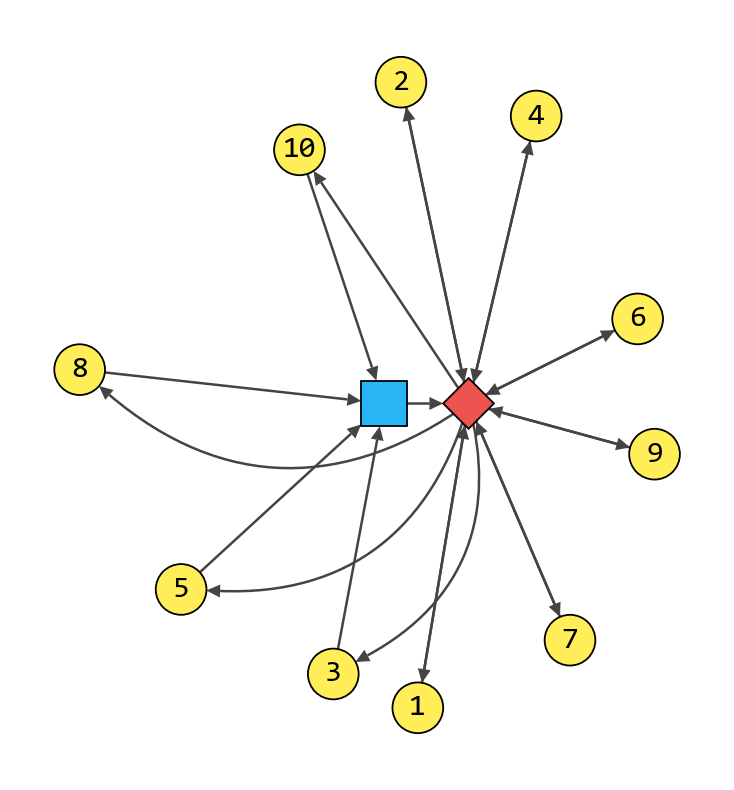

In [16]:
def find_cycle_points(A, start_point):
    # 记录已访问的节点
    visited = set()
    # 存储结果的列表
    cycle_points = []

    # 深度优先搜索
    def dfs(node):
        visited.add(node)
        cycle_points.append(node)

        for next_node in range(len(A[node])):
            if next_node not in visited and A[node][next_node] > 0.5:
                dfs(next_node)

    # 从起点开始搜索
    dfs(start_point)

    return cycle_points

def draw_graph(df, charge_station, shops, paths):
    
    g = ig.Graph(directed=True)
    
    user_number = df.shape[0]
    shop_number = len(shops)
    total_nodes = 1 + shop_number + user_number
    # 添加点顺序：充电站--商店--顾客
    g.add_vertices(total_nodes)
    g.vs["x"] = ([charge_station[0]] + 
                 [shops[i][0] for i in range(len(shops))]+
                 [df1.points[i][0] for i in range(len(df1.points))])
    g.vs["y"] = ([charge_station[1]] + 
                 [shops[i][1] for i in range(len(shops))]+
                 [df1.points[i][1] for i in range(len(df1.points))])
    g.vs["shape"] = ["rectangle", "diamond"] + ["circle" for _ in range(user_number)]
    g.vs["color"] = ["#29B6F6", "#EF5350"] + ["#FFEE58" for _ in range(user_number)]
    g.vs["size"] = [0.27, 0.3] + [0.3 for _ in range(user_number)]
    
    # 建立path点到图中点的映射字典
    point_dict = {}
    for i in range(1, 2 * user_number + 1):
        point_dict[i] = ((i - 1) % user_number) + 1 + shop_number
    
    # 遍历path添加边
    for i in range(len(paths) - 1):
        if i == 0:
            start_point = 0
            mid_point = 1
            end_point = point_dict[paths[i + 1]]
            # 添加两条边
            g.add_edge(start_point, mid_point)
            # g.add_edge(mid_point, end_point)
            # 添加访问编号
            g.vs[end_point]["label"] = i + 1
            g.vs[end_point]["label_size"] = 22
            continue
        elif i == len(paths) - 2:
            start_point = point_dict[paths[i]]
            mid_point = 1
            end_point = 0
            # 添加一条边
            g.add_edge(mid_point, start_point, curved=-0.0)
            g.add_edge(start_point, end_point)
            continue
            
        # 中间的情况
        if 1 <= paths[i + 1] <= user_number:
            # 不充电
            start_point = point_dict[paths[i]]
            mid_point = 1
            end_point = point_dict[paths[i + 1]]
            g.add_edge(mid_point, start_point, curved=0)
            g.add_edge(start_point, mid_point, curved=0)
            g.vs[end_point]["label"] = i + 1
            g.vs[end_point]["label_size"] = 22
        elif user_number + 1 <= paths[i + 1] <= 2 * user_number + 1:
            start_point = point_dict[paths[i]]
            mid_point1 = 0
            mid_point2 = 1
            end_point = point_dict[paths[i + 1]]
            g.add_edge(mid_point2, start_point, curved=0.5)
            g.add_edge(start_point, mid_point1, curved=0)
            #g.add_edge(mid_point1, start_point, curved=0)
            
            
            g.vs[end_point]["label"] = i + 1
            g.vs[end_point]["label_size"] = 22
    
    return g

xMat = np.zeros((matSize, matSize))
for i in range(matSize):
    for j in range(matSize):
        xMat[i, j] = x[i, j].x
        
Paths = find_cycle_points(xMat, 0)

g = draw_graph(df1, chargeStation, shop, Paths)

layout = g.layout_auto()
fig, ax = plt.subplots(figsize=(40, 10))
ig.plot(g, target=ax, layout=layout, edge_width=1.8, vertex_frame_width=1.3, edge_arrow_size=0.006)

plt.savefig('q1工作路径.svg', format="svg",bbox_inches='tight',pad_inches=-0.4)

In [3]:
## 灵敏度分析
q1MaxTime = []

for alpha in np.arange(0.5,1.5,0.1):
    cur_droneMaxPower = droneMaxPower * alpha
    print(cur_droneMaxPower)

    # 确认分块点集
    Sp = [0]
    Ep = [matSize - 1]
    I1 = list(range(1, userNumber + 1))
    I2 = list(range(userNumber + 1, 2 * userNumber + 1))
    U = Sp + I1 + I2 + Ep
    
    
    prob1 = gp.Model('q1无人机调度')
    
    x = prob1.addVars(matSize, matSize, vtype=GRB.BINARY, name='workingPath')
    phi = prob1.addVars(matSize, lb=0, ub=cur_droneMaxPower, vtype=GRB.CONTINUOUS, name='remainPower')
    u = prob1.addVars(matSize, vtype=GRB.INTEGER, name='order')
    
    ## 约束
    
    # 不可能路径约束
    prob1.addConstr(gp.quicksum(x[i, j] for i in (Sp + I1 + I2 + Ep) for j in Sp) == 0)
    prob1.addConstr(gp.quicksum(x[i, j] for i in Sp for j in (I2 + Ep)) == 0)
    prob1.addConstr(gp.quicksum(x[i, j] for i in Ep for j in (I1 + I2 + Ep)) == 0)
    prob1.addConstrs(x[i, i] == 0 for i in I1 + I2)
    
    # 起点终点约束
    prob1.addConstr(gp.quicksum(x[0, j] for j in I1) == 1)
    prob1.addConstr(gp.quicksum(x[i, matSize - 1] for i in (I1 + I2)) == 1)
    
    # 顾客服务约束
    for i in range(1, userNumber + 1):
        pos1 = i
        pos2 = i + userNumber
        prob1.addConstr(gp.quicksum(x[pos1, j] + x[pos2, j] for j in (Sp + I1 + I2 + Ep)) == 1)
    
    # 连续路径约束
    for i in range(1, matSize - 2):
        prob1.addConstr(gp.quicksum(x[i, j] for j in (Sp + I1 + I2 + Ep)) == 
                        gp.quicksum(x[j, i] for j in (Sp + I1 + I2 + Ep)))
    
    # MTZ约束
    # 起点
    prob1.addConstr(u[0] == 1)
    # 起点到第一个顾客
    prob1.addConstrs(u[i] - u[j] + matSize * x[i, j] <= matSize - 1 for i in Sp for j in I1)
    # 顾客到顾客
    prob1.addConstrs(u[i] - u[j] + matSize * x[i, j] <= matSize - 1 for i in (I1 + I2) for j in (I1 + I2))
    # 顾客到终点
    prob1.addConstrs(u[i] - u[j] + matSize * x[i, j] <= matSize - 1 for i in (I1 + I2) for j in Ep)
    
    # 起始电量
    prob1.addConstr(phi[0] == cur_droneMaxPower)
    
    # 不充电
    for i in (Sp + I1 + I2):
        for j in I1:
            prob1.addConstr(phi[j] <= phi[i] - distMat[i, j] + M * (1 - x[i, j]))
            prob1.addConstr(phi[j] >= phi[i] - distMat[i, j] - M * (1 - x[i, j]))
    for i in (I1 + I2):
        for j in Ep:
            prob1.addConstr(phi[j] <= phi[i] - distMat[i, j] + M * (1 - x[i, j]))
            prob1.addConstr(phi[j] >= phi[i] - distMat[i, j] - M * (1 - x[i, j]))
    
    # 充电
    for i in (I1 + I2):
        for j in I2:
            prob1.addConstr(phi[j] <= cur_droneMaxPower - distMat[0, j % userNumber] + M * (1 - x[i, j]))
            prob1.addConstr(phi[j] >= cur_droneMaxPower - distMat[0, j % userNumber] - M * (1 - x[i, j]))
    
    ## 目标函数
    prob1.setObjective(gp.quicksum(x[i, j] * distMat[i, j] for i in U for j in U))
    
    prob1.Params.NoRelHeurTime = 8
    prob1.Params.TimeLimit = 8
    prob1.optimize()
    
    q1MaxTime.append(prob1.objVal)

5.0
Set parameter NoRelHeurTime to value 8
Set parameter TimeLimit to value 8
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1346 rows, 528 columns and 4734 nonzeros
Model fingerprint: 0x4dd9bddc
Variable types: 22 continuous, 506 integer (484 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [2e+00, 7e+04]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 613 rows and 250 columns
Presolve time: 0.03s
Presolved: 733 rows, 278 columns, 3462 nonzeros
Variable types: 21 continuous, 257 integer (237 binary)
Starting NoRel heuristic
Found phase-1 solution: relaxation 6
Found phase-1 solution: relaxation 1
Found phase-1 solution: relaxation 0
Found heuristic solution: objective 38.5064103
Transition to phase 2
Found heuristic solut

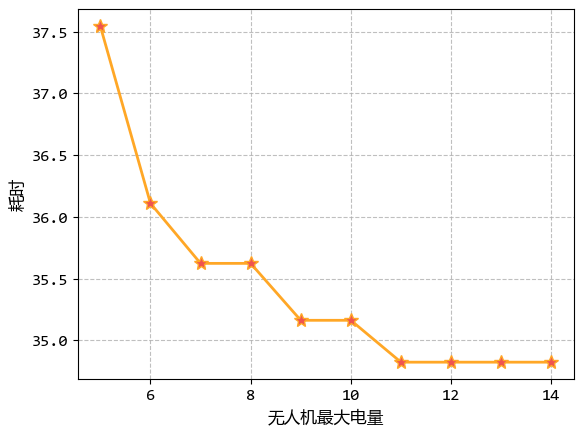

In [36]:
# 创建一个新的图形
plt.figure()
# 绘制第一个列表的折线图
plt.plot(np.arange(0.5, 1.5, 0.1) * droneMaxPower, q1MaxTime, marker='*', markersize=10, markerfacecolor='#EF5350', color='#FFA726', linestyle='-', linewidth=2)

# 添加坐标轴名称
plt.xlabel('无人机最大电量')
plt.ylabel('耗时')
plt.grid(ls='--',alpha=0.8)
plt.savefig('q1电量灵敏度分析.svg', format='svg')


In [20]:
# 生成问题一结果报告
import time
def mycallback(model, where):
    if where == GRB.Callback.MIP:
        # MIP solution callback
        currentTime = time.time()
        solName = int((currentTime - model._startTime) / model._interval) * model._interval
        
        # Statistics
        obj = model.cbGet(GRB.Callback.MIP_OBJBST)

        # Export statistics
        msg = str(currentTime-model._startTime) + " " + str(obj) + "\n"
        model._reportFile.write(msg)
        model._reportFile.flush()
        
model = gp.read('q1model.lp')
# 求解参数
model.Params.NoRelHeurTime = 5
model.Params.TimeLimit = 5

reportFile = open('q1report.txt', 'w')

model._startTime = time.time()
model._reportFile = reportFile
model._interval = 1  #每隔一段时间输出当前可行解，单位秒

model.optimize(mycallback)





Read LP format model from file q1model.lp
Reading time = 0.01 seconds
: 1346 rows, 528 columns, 4734 nonzeros
Set parameter NoRelHeurTime to value 5
Set parameter TimeLimit to value 5
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1346 rows, 528 columns and 4734 nonzeros
Model fingerprint: 0xc33dd8fa
Variable types: 22 continuous, 506 integer (484 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [2e+00, 7e+04]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+05]
Presolve removed 343 rows and 115 columns
Presolve time: 0.06s
Presolved: 1003 rows, 413 columns, 6115 nonzeros
Variable types: 21 continuous, 392 integer (372 binary)
Starting NoRel heuristic
Found phase-1 solution: relaxation 4
Found phase-1 solution: relaxation 0
Found heuristic solu

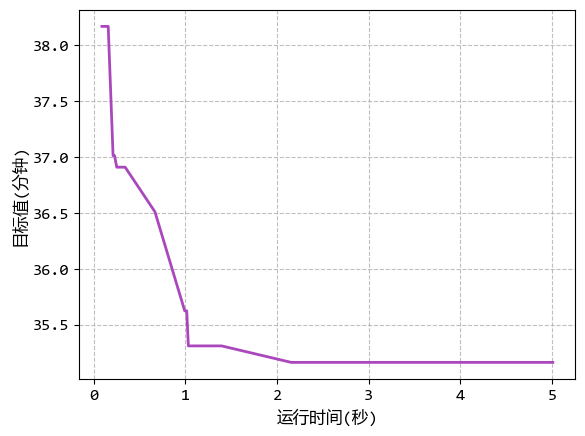

In [37]:
# 绘制收敛曲线
def read_report(filepath,save_name):
    # 存储数据的列表
    timestamps = []
    obj_values = []

    # 读取txt文件
    with open(filepath, 'r') as file:
        for line in file:
            # 分割每行的数据
            parts = line.split(' ')
            timestamp = float(parts[0].strip())
            obj_value = float(parts[1].strip())
            timestamps.append(timestamp)
            obj_values.append(obj_value)
    # 绘制图形
    plt.plot(timestamps, obj_values, color='#AB47BC', linestyle='-', linewidth=2)
    plt.xlabel('运行时间(秒)')
    plt.ylabel('目标值(分钟)')
    plt.grid(ls='--',alpha=0.8)
    plt.savefig(save_name, format='svg')

read_report('./q1report.txt','q1收敛曲线.svg')